In [15]:
img_height, img_width = 256, 256
batch_size = 1
sar_dir = r'C:\Users\kanad\Downloads\Sentinel Data\Sentinel Data\s1'
optical_dir = r'C:\Users\kanad\Downloads\Sentinel Data\Sentinel Data\s2'

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
import matplotlib.pyplot as plt

In [17]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def preprocess_image(sar_file, optical_file):
    sar_image = load_image(sar_file)
    optical_image = load_image(optical_file)
    return sar_image, optical_image

def load_dataset(sar_dir, optical_dir):
    sar_files = glob.glob(os.path.join(sar_dir, '*.png'))
    optical_files = glob.glob(os.path.join(optical_dir, '*.png'))
    dataset = tf.data.Dataset.from_tensor_slices((sar_files, optical_files))
    dataset = dataset.map(preprocess_image).batch(batch_size)
    return dataset

In [18]:
def build_generator():
    inputs = layers.Input(shape=[img_height, img_width, 1])

    # Encoder (downsampling)
    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    # Bottleneck
    bottleneck = layers.Conv2D(512, 4, strides=2, padding='same')(down3)
    bottleneck = layers.ReLU()(bottleneck)

    # Decoder (upsampling)
    up1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(bottleneck)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.ReLU()(up1)

    up2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(up1)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.ReLU()(up2)

    up3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(up2)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.ReLU()(up3)

    # Output layer
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up3)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [19]:
def build_discriminator():
    inp = layers.Input(shape=[img_height, img_width, 1], name='input_image')
    tar = layers.Input(shape=[img_height, img_width, 3], name='target_image')

    combined = layers.concatenate([inp, tar])

    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(combined)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    down4 = layers.Conv2D(512, 4, strides=2, padding='same')(down3)
    down4 = layers.BatchNormalization()(down4)
    down4 = layers.LeakyReLU()(down4)

    outputs = layers.Conv2D(1, 4, strides=1, padding='same')(down4)

    return tf.keras.Model(inputs=[inp, tar], outputs=outputs)

In [20]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
def train_step(input_image, target, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs, generator, discriminator):
    for epoch in range(epochs):
        for input_image, target in dataset:
            train_step(input_image, target, generator, discriminator)

In [23]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Actual Image', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)  # Rescale back to [0,1]
        plt.axis('off')
    plt.show()


In [24]:
test_dataset = load_dataset(sar_dir, optical_dir)
generator = build_generator()
discriminator = build_discriminator()

# Train the model (replace `epochs` with desired number)
train(test_dataset, epochs=7, generator=generator, discriminator=discriminator)

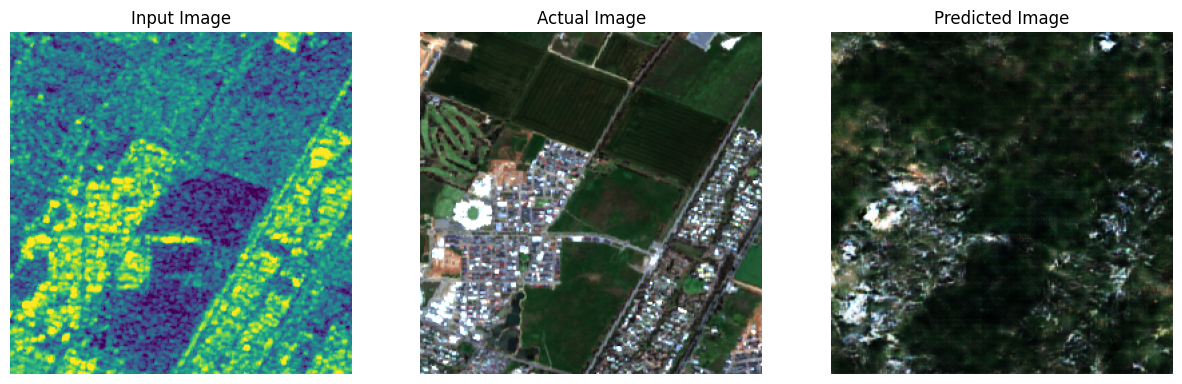

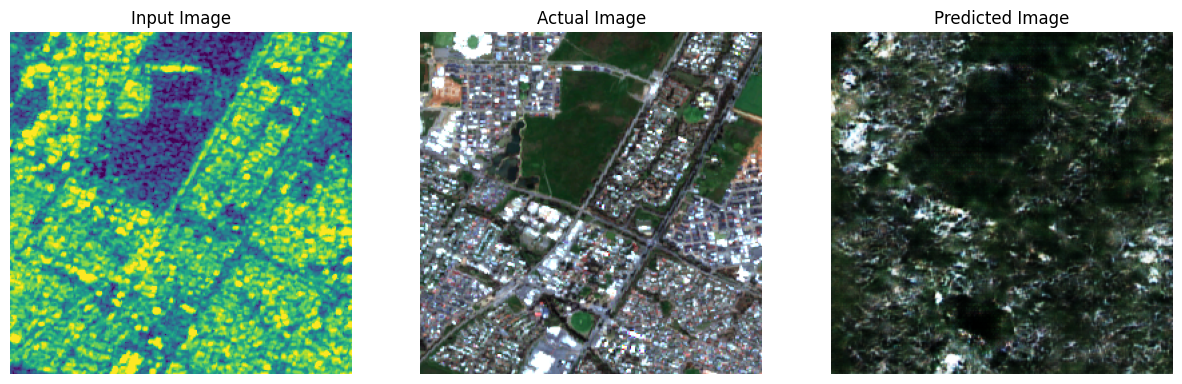

In [25]:
for example_input, example_target in test_dataset.take(2):
    generate_images(generator, example_input, example_target)